# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Softmax-exercise" data-toc-modified-id="Softmax-exercise-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Softmax exercise</a></div><div class="lev2 toc-item"><a href="#Softmax-Classifier" data-toc-modified-id="Softmax-Classifier-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Softmax Classifier</a></div><div class="lev2 toc-item"><a href="#Inline-Question-1:" data-toc-modified-id="Inline-Question-1:-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Inline Question 1:</a></div>

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000L, 3073L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 3073L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 3073L)
Test labels shape:  (1000L,)
dev data shape:  (500L, 3073L)
dev labels shape:  (500L,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [12]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.327288
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Because softmax can be seen as $p(y|x)$ there are 10 classes and the random probability is 1:10.


In [10]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.101275 analytic: -2.101276, relative error: 3.748176e-08
numerical: -1.228198 analytic: -1.228198, relative error: 4.037207e-08
numerical: 0.267969 analytic: 0.267969, relative error: 2.730971e-08
numerical: -0.674349 analytic: -0.674349, relative error: 3.767886e-08
numerical: 1.564551 analytic: 1.564551, relative error: 3.753580e-08
numerical: 1.283980 analytic: 1.283980, relative error: 1.053941e-08
numerical: -3.670281 analytic: -3.670281, relative error: 2.261679e-08
numerical: 1.172705 analytic: 1.172705, relative error: 6.053440e-08
numerical: 2.990430 analytic: 2.990429, relative error: 1.546051e-08
numerical: 2.929941 analytic: 2.929941, relative error: 1.336171e-08
numerical: 0.333384 analytic: 0.333384, relative error: 1.366564e-09
numerical: 0.855520 analytic: 0.855520, relative error: 1.098697e-07
numerical: 2.193422 analytic: 2.193422, relative error: 4.845454e-08
numerical: -3.273660 analytic: -3.273660, relative error: 9.875578e-09
numerical: -0.243458 ana

In [27]:
h = np.array([1,2,3,4])
h = h.reshape(2,2)
np.max(h, axis=0)

array([3, 4])

In [46]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.327288e+00 computed in 0.751000s
vectorized loss: 2.327288e+00 computed in 0.031000s
Loss difference: 0.000000
Gradient difference: 0.000000


In [57]:
from cs231n.classifiers import Softmax
smax = Softmax()
tic = time.time()
loss_hist = smax.train(X_train, y_train, learning_rate=5e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 386.209100
iteration 100 / 1500: loss 32.487190
iteration 200 / 1500: loss 4.546922
iteration 300 / 1500: loss 2.241230
iteration 400 / 1500: loss 2.028218
iteration 500 / 1500: loss 2.026722
iteration 600 / 1500: loss 2.085486
iteration 700 / 1500: loss 2.083457
iteration 800 / 1500: loss 2.001159
iteration 900 / 1500: loss 2.042844
iteration 1000 / 1500: loss 2.013671
iteration 1100 / 1500: loss 2.108793
iteration 1200 / 1500: loss 1.997256
iteration 1300 / 1500: loss 2.021650
iteration 1400 / 1500: loss 2.053931
That took 17.495000s


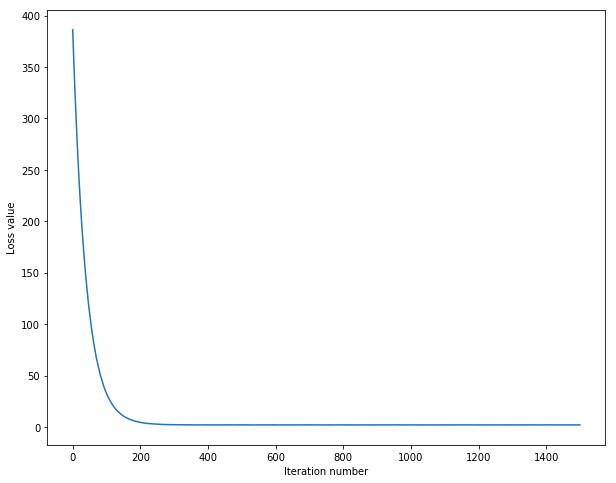

In [58]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [59]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = smax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = smax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.346653
validation accuracy: 0.356000


In [54]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

span = 3
num_iterarions=600

learning_rates = np.linspace(learning_rates[0],learning_rates[1],span)
regularization_strengths = (regularization_strengths[0], regularization_strengths[1],span)

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
      smax = Softmax()
      loss_hist = smax.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength, num_iters=num_iterarions, verbose=True)
      y_train_pred = smax.predict(X_train)
      y_val_pred = smax.predict(X_val)
      training_accuracy = np.mean(y_train == y_train_pred)
      validation_accuracy = np.mean(y_val == y_val_pred)
      results[(learning_rate, regularization_strength)] = (training_accuracy, validation_accuracy)
      if validation_accuracy > best_val:
        best_val = validation_accuracy   # The highest validation accuracy that we have seen so far.
        best_smax = smax # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 600: loss 392.093181
iteration 100 / 600: loss 237.447196
iteration 200 / 600: loss 144.396804
iteration 300 / 600: loss 88.004906
iteration 400 / 600: loss 54.065062
iteration 500 / 600: loss 33.484261
iteration 0 / 600: loss 779.185477
iteration 100 / 600: loss 285.938832
iteration 200 / 600: loss 105.934081
iteration 300 / 600: loss 40.037144
iteration 400 / 600: loss 15.961355
iteration 500 / 600: loss 7.157936
iteration 0 / 600: loss 5.706229
iteration 100 / 600: loss 3.989751
iteration 200 / 600: loss 3.317907
iteration 300 / 600: loss 3.680860
iteration 400 / 600: loss 3.209117
iteration 500 / 600: loss 3.122873
iteration 0 / 600: loss 392.119480
iteration 100 / 600: loss 86.967791
iteration 200 / 600: loss 20.843378
iteration 300 / 600: loss 6.095735
iteration 400 / 600: loss 2.913785
iteration 500 / 600: loss 2.162364
iteration 0 / 600: loss 772.298228
iteration 100 / 600: loss 39.225004
iteration 200 / 600: loss 3.863673
iteration 300 / 600: loss 2.164248
iterat

In [60]:
best_softmax = smax
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.363000


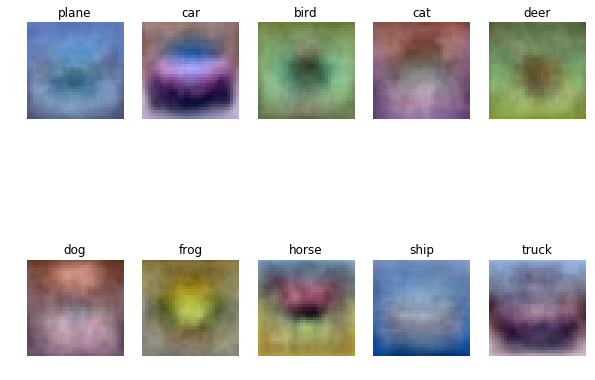

In [61]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])